In [1]:
import torch
import matplotlib.pyplot as plt
import plotly.express as px
import sys
import glob
import json
import numpy as np
from tqdm import tqdm
sys.path.append("../")

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
norms  = np.load("/app/dataset/various_splits/all_layout/normalizers/normalizers.npy",allow_pickle=True).item()

In [3]:
opcode_name = json.load(open("/app/nn-runtime-network/assets/opt_code.json"))
feature_vec_name = json.load(open("/app/nn-runtime-network/assets/node_feature_vector.json"))

In [4]:
import glob
import os
import pandas as pd

def get_npy_files(root_path):
    # Use a glob pattern to match all .npz files in the directory and subdirectories
    pattern = os.path.join(root_path, '**', '*.npz')
    npy_files = glob.glob(pattern, recursive=True)
    return npy_files

all_npy_files = get_npy_files("/app/dataset/npz_all/npz/layout")+get_npy_files("/app/dataset/npz_all/npz/tile/xla")
print(len(all_npy_files))
# Create a DataFrame from the list of npy files
df = pd.DataFrame(all_npy_files, columns=["path"])
print(len(df))
def find_split(x):
    if "/train" in x:
        return "train"
    elif "/valid" in x:
        return "valid"
    elif "/test" in x:
        return "test"
    return None
def find_configtype(x):
    if "/default" in x:
        return "default"
    elif "/random" in x:
        return "random"
    return "istile"
def find_modeltype(x):
    if "/nlp" in x:
        return "nlp"
    elif "/xla" in x:
        return "xla"
    return None
def find_grapthtype(x):
    if "/layout" in x:
        return "layout"
    elif "/tile" in x:
        return "tile"
    return None
df["split"] = df.path.apply(lambda x : find_split(x))
df["config_type"] = df.path.apply(lambda x : find_configtype(x))
df["modeltype"] = df.path.apply(lambda x : find_modeltype(x))
df["graphtype"] = df.path.apply(lambda x : find_grapthtype(x))
df["modelname"] = df.path.apply(lambda x: x.split("/")[-1])

7868
7868


In [5]:
df = df[df["graphtype"]=="layout"]

In [6]:
features = []
for pth in tqdm(df["path"]):
    feats = np.load(pth)
    features.append(feats["node_feat"])

100%|██████████| 639/639 [00:05<00:00, 124.25it/s]


In [7]:
features = np.concatenate(features,0)

/tmp/ipykernel_3580850/1091861131.py:15: RuntimeWarning: divide by zero encountered in log2
  x_log = np.log2(x)


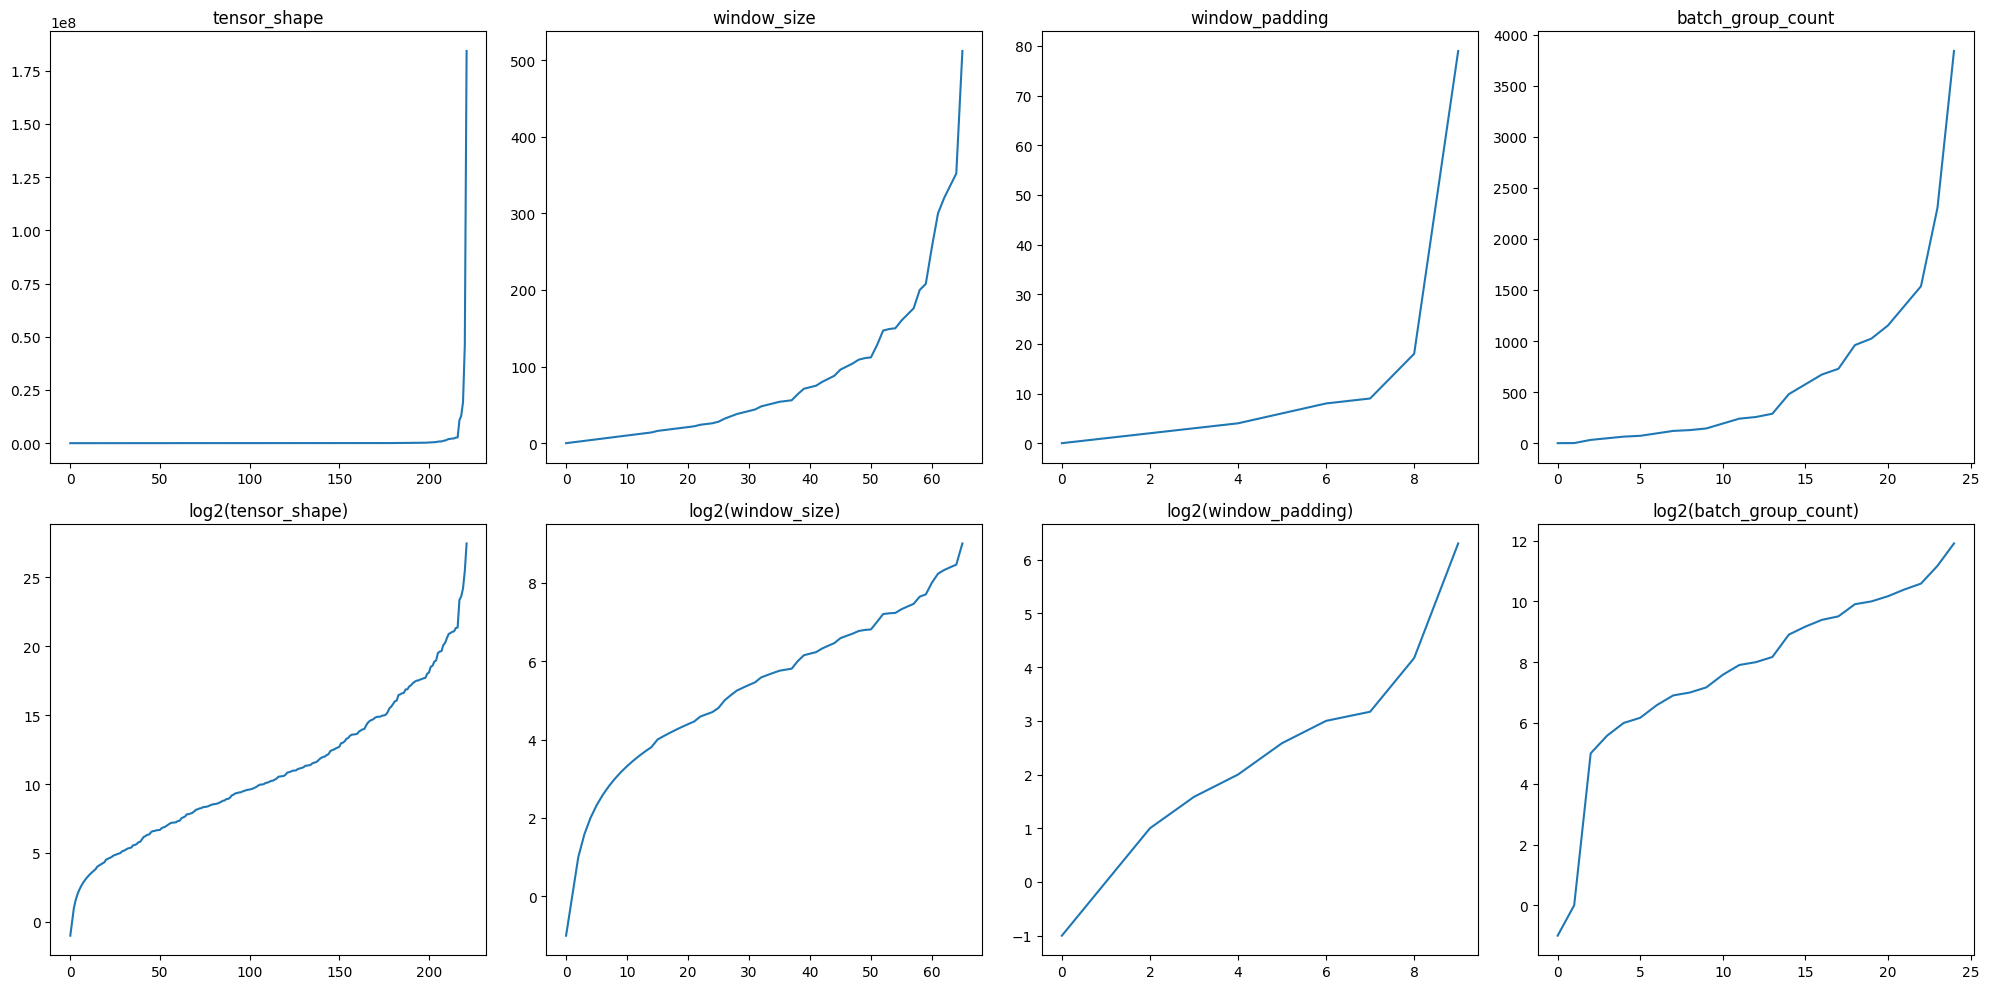

In [35]:
dims = [21,37,53,108]
names = ["tensor_shape","window_size","window_padding","batch_group_count"]
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for i, (dim, name) in enumerate(zip(dims, names)):
    # Original data plot
    x = features[:, dim ]  # Adjusting for 0-indexing
    x = np.unique(x)
    x.sort()
    axs[0, i].plot(x)
    axs[0, i].set_title(f"{name}")

    # Log2 plot
    mask = x <= 0
    x_log = np.log2(x)
    x_log[mask] = -1
    axs[1, i].plot(x_log)
    axs[1, i].set_title(f"log2({name})")

# Adjust layout for clarity
plt.tight_layout()
plt.show()

In [6]:
import networkx as nx
import numpy as np

def count_nodes_within_n_hops(edges, sample_nodes):
    # Create a graph from the edges
    G = nx.Graph()
    G.add_edges_from(edges)

    # Initialize a dictionary to store the count of unique nodes within each hop
    hop_counts = {n: 0 for n in range(6)}

    # At 0 hops, it's just the count of unique sampled nodes
    unique_sample_nodes = set(sample_nodes)
    hop_counts[0] = len(unique_sample_nodes)

    # Accumulate unique nodes within each hop
    accumulated_nodes = set(unique_sample_nodes)

    for n in range(1, 6):
        for node in unique_sample_nodes:
            if node not in G:
                continue  # Skip if the sampled node is not in the graph

            # Find nodes within n hops
            nodes_within_n_hops = nx.single_source_shortest_path_length(G, node, cutoff=n)
            accumulated_nodes.update(nodes_within_n_hops.keys())

        hop_counts[n] = len(accumulated_nodes)

    return hop_counts

In [33]:
def features(f):
    info = np.load(f)
    return {
        "config_nodes": info["node_config_ids"].shape[0],
        "nodes": info["node_feat"].shape[0],
        "edges": info["edge_index"].shape[0],
        "config_runtime": info["config_runtime"].shape[0]
    }
config_nodes = []
config_runtime = []
nodes = []
edges = []
hop_counts = []
for pth in tqdm(df.path):
    feats = features(pth)
    config_nodes.append(feats["config_nodes"])
    nodes.append(feats["nodes"])
    edges.append(feats["edges"])
    config_runtime.append(feats["config_runtime"])
    feats = np.load(pth)
    hop_counts.append(count_nodes_within_n_hops(feats["edge_index"], feats["node_config_ids"]))

df["config_nodes"] = config_nodes
df["nodes"] = nodes
df["edges"] = edges
df["config_runtime"] = config_runtime


100%|██████████| 639/639 [08:10<00:00,  1.30it/s]


In [34]:
df["ratio of config nodes"] = df["config_nodes"]/df["nodes"]

In [52]:
for i in range(0,6):
    df[f"ratio of nodes @ hop {i}"] = np.array([x[i] for x in hop_counts])/df["nodes"]

In [39]:
df[['split', 'config_type', 'modeltype', 'config_nodes', 'nodes', 'edges','config_runtime']].groupby(['modeltype','config_type','split']).agg(["mean","count"]).round()

config_nodes          nodes          edges        \
                                    mean count     mean count     mean count   
modeltype config_type split                                                    
nlp       default     test         188.0    17   4513.0    17   7300.0    17   
                      train        245.0   198   5890.0   198   9608.0   198   
                      valid        216.0    20   5610.0    20   9160.0    20   
          random      test         188.0    17   4513.0    17   7300.0    17   
                      train        240.0   207   5758.0   207   9389.0   207   
                      valid        216.0    20   5610.0    20   9160.0    20   
xla       default     test        1154.0     8  23560.0     8  39018.0     8   
                      train        656.0    61  12911.0    61  21705.0    61   
                      valid        685.0     7  12797.0     7  21777.0     7   
          random      test        1154.0     8  23560.0     8  39018.0     8   
                      train        691.0    69  12745.0    69  21321.0    69   
                      valid        685.0     7  12797.0     7  21777.0     7   

                            config_runtime        
                                      mean count  
modeltype config_type split                       
nlp       default     test          1000.0    17  
                      train        64505.0   198  
                      valid        70069.0    20  
          random      test          1000.0    17  
                      train        65012.0   207  
                      valid        68731.0    20  
xla       default     test          1000.0     8  
                      train        17159.0    61  
                      valid         9432.0     7  
          random      test          1000.0     8  
                      train        14579.0    69  
                      valid         8544.0     7

In [42]:
df.columns

Index(['path', 'split', 'config_type', 'modeltype', 'graphtype', 'modelname',
       'config_nodes', 'nodes', 'edges', 'config_runtime', 'percent of config',
       'ratio of config nodes', 'ratio of config nodes @ hop 0',
       'ratio of config nodes @ hop 1', 'ratio of config nodes @ hop 2',
       'ratio of config nodes @ hop 3', 'ratio of config nodes @ hop 4',
       'ratio of config nodes @ hop 5'],
      dtype='object')

In [ ]:
df = pd.read_csv("")

In [62]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# Sample DataFrame (replace this with your actual DataFrame)
# df = pd.DataFrame({
#     'ratio of config nodes': [...],
#     'ratio of config nodes @ hop 0': [...],
#     ...
# })

# List of columns for which you want to create histograms
columns = ['ratio of nodes @ hop 0',
           'ratio of nodes @ hop 1', 'ratio of nodes @ hop 2',
           'ratio of nodes @ hop 3', 'ratio of nodes @ hop 4',
           'ratio of nodes @ hop 5']

# Determine the layout of the grid (rows x columns)
num_plots = len(columns)
rows = int(num_plots ** 0.5)
cols = (num_plots // rows) + (num_plots % rows > 0)

# Create a subplot grid
fig = make_subplots(rows=rows, cols=cols, subplot_titles=columns)

# Add a histogram to each subplot
for i, column in enumerate(columns, 1):
    row = (i-1) // cols + 1
    col = (i-1) % cols + 1
    fig.add_trace(
        go.Histogram(x=df[column], opacity=1,nbinsx=50),
        row=row, col=col
    )

# Update layout
fig.update_layout(height=400 * rows, width=400 * cols, title_text="Ratio of Nodes Traversed at N-Hop from Config Nodes",showlegend=False)
fig.show()


In [50]:
px.histogram(df,x=['ratio of config nodes', 'ratio of config nodes @ hop 0',
       'ratio of config nodes @ hop 1', 'ratio of config nodes @ hop 2',
       'ratio of config nodes @ hop 3', 'ratio of config nodes @ hop 4',
       'ratio of config nodes @ hop 5'],opacity=0.5,nbins=50)

In [21]:
info = np.load(df.path[0])

In [9]:
path = df[(df.modeltype=="xla")&(df.graphtype=="layout")&(df.split=="train")].path.to_list()[0]
path = [x for x in df.path.to_list() if "unet3d" in x][0]

In [10]:
data = dict(np.load(path))

In [11]:
def node_config_feat_string(inf):
    outstr = "x".join([str(int(i)) for i in inf[:6]])
    inpstr = "x".join([str(int(i)) for i in inf[6:12]])
    kernstr = "x".join([str(int(i)) for i in inf[12:]])
    return f"out: {outstr},inp: {inpstr}, kern: {kernstr}"
def node_feat_string(inf):
    layoutminmaj = "x".join([str(int(i)) for i in inf[134:]])
    shapdim = "x".join([str(int(i)) for i in inf[21:27] ])
    dimensions = "x".join([str(int(i)) for i in inf[31:37] ])
    convdims = "x".join([str(int(i)) for i in inf[93:106]])
    return f"lay:{layoutminmaj},shape:{shapdim},dims:{dimensions}\n convdim:{convdims}"

In [13]:
import matplotlib.pyplot as plt
import networkx as nx
from pyvis.network import Network
import numpy as np
import matplotlib

# Initialize a directed networkx graph
G = nx.DiGraph()

# Add nodes with attributes to the graph
for idx, opcode in enumerate(data['node_opcode']):
    G.add_node(int(idx), opcode=int(opcode))

# Add directed edges to the graph
edges = data['edge_index']
for edge in edges:
    G.add_edge(int(edge[1]), int(edge[0]))


nodes_to_keep = list(nx.bfs_tree(G, source=0, depth_limit=999))  # This assumes node IDs start at 0

nodes_to_keep = nodes_to_keep[:1000]

G = G.subgraph(nodes_to_keep).copy()

nt = Network("800px", "100%", notebook=False, heading='Directed Graph Visualization', directed=True)

# Create a colormap with matplotlib
colormap = plt.get_cmap('nipy_spectral')
norm = plt.Normalize(min(data['node_opcode']), max(data['node_opcode']))

opcode_colors = {opcode: colormap(norm(opcode)) for opcode in data['node_opcode']}

# Take the networkx graph and translate it to a pyvis graph
nt.from_nx(G)
nodeconf_ids =  data["node_config_ids"].tolist()
# Set options for nodes
for node in nt.nodes:
    opcode = G.nodes[node['id']]['opcode']
    nodestring = f"Opcode: {opcode_name[str(opcode)]}"

    color = matplotlib.colors.rgb2hex(opcode_colors[opcode])  # Convert RGBA to hex
    if node["id"] in nodeconf_ids:
        idx = nodeconf_ids.index(node["id"])
        nodestring = nodestring+"\n conf1>"+node_config_feat_string(data["node_config_feat"][0,idx])
        nodestring = nodestring+"\n conf2>"+node_config_feat_string(data["node_config_feat"][len(data["node_config_feat"])//2,idx])
        nodestring = nodestring+"\n conf3>"+node_config_feat_string(data["node_config_feat"][len(data["node_config_feat"])-1,idx])
    nodestring = nodestring+ "\n node>"+node_feat_string(data["node_feat"][node["id"]])
    node["title"] = nodestring
    node["label"] = ''  # You can remove or set to some label you want to show
    node["color"] = color
    node["size"] = 10 if opcode not in [2,26,75,34,63] else 20
    node["value"] = node["size"] 

# Set the physics layout and interaction options of the network
nt.set_options("""
var options = {
  "nodes": {
    "font": {
      "size": 12
    }
  },
  "edges": {
    "color": {
      "inherit": true
    },
    "arrows": {
      "to": { "enabled": true, "scaleFactor": 0.5 }
    },
    "smooth": false
  },
  "physics": {
    "forceAtlas2Based": {
      "gravitationalConstant": -26,
      "centralGravity": 0.005,
      "springLength": 230,
      "springConstant": 0.18
    },
    "maxVelocity": 2,
    "solver": "forceAtlas2Based",
    "timestep": 0.35,
    "stabilization": { "iterations": 150 }
  }
}
""")

# Save the graph to an HTML file
nt.write_html('graph.html')


In [135]:
path

'/app/dataset/npz_all/npz/layout/xla/default/train/alexnet_train_batch_32.npz'